# <b>Required Imports</b>

In [1]:
import pickle,sys,os, time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

print(tf.__version__)

BYPASS_PREVIOUS_SECTION = [True, False][0]

2.7.0


In [2]:
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset0.pkl?raw=true
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset1.pkl?raw=true
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset2.pkl?raw=true
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset3.pkl?raw=true

--2021-12-31 16:27:40--  https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset0.pkl?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/GastonMazzei/TraceMeOut/raw/main/processed_trace/Dataset0.pkl [following]
--2021-12-31 16:27:40--  https://github.com/GastonMazzei/TraceMeOut/raw/main/processed_trace/Dataset0.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GastonMazzei/TraceMeOut/main/processed_trace/Dataset0.pkl [following]
--2021-12-31 16:27:40--  https://raw.githubusercontent.com/GastonMazzei/TraceMeOut/main/processed_trace/Dataset0.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [3]:
!ls

'Dataset0.pkl?raw=true'  'Dataset2.pkl?raw=true'   sample_data
'Dataset1.pkl?raw=true'  'Dataset3.pkl?raw=true'


In [4]:
if not BYPASS_PREVIOUS_SECTION:
  datas = {}
  for n in [0,1,2,3]:
    with open(f'Dataset{n}.pkl?raw=true','rb') as f:
      datas[n] = pickle.load(f)

#<b>Configuration File: architecture & hyperparameters</b>

(<i>If the datasets change in the repo, non-architectural information should be updated using the configuration.py file. Most probably an error will be raised because of size mismatch if this is not updated.</i>)
<b>IF it's not the first run, and you have accepted to store the data in GoogleColab, you can skip to the next section :-)</b>

In [38]:
# Model-specific parameters
T=8 # duration of the window in dt units
dt = 4000 # time in microseconds
UNIQUES=3807  #number of unique ids
MI=4762  #max number of interactions
ML=4765  #max number of leaves
NCATEGORIES=2

# Architectural parameters
ACT1 = 'relu'
FILTERS1 = 8
KSIZE1 = (2,1)
PSIZE1 = (max([T//4,2]),)
NDENSE1 = 8
DROP1 = 0.4

ACT2 = 'relu'
FILTERS2 = 8
KSIZE2 = (2,2)
PSIZE2 = (max([T//2,2]),1)
stride = (1,1)
NDENSE2 = 8
DROP2 = 0.5


ACT4='relu'
NDENSE4=8
DROP4 = 0.3


ACT3='relu'
NDENSE3=8
DROP3 = 0.3


# Training parameters
VAL=0.25
BATCH=128
EPOCHS=20
L=5 # a length used to generate random data just for testing
LR=0.01
SAMPLES = 30


# Extras
POOLING = False
PROCS=[3, 2, 0, 1]

In [39]:
# Assert the dataset's keys and the procs in the configuration are the same :-)
temp1, temp2 = sorted(PROCS), sorted(list(datas.keys()))
assert(temp1 == temp2)
NPROCS = len(PROCS)

# define two sets of inputs: 
MAXPAD = max([MI,ML])
input_shape_flavours = (BATCH, T, MAXPAD, 1)
input_shape_structure = (BATCH, T, MAXPAD, 2)

def produce_model():
	inputFlavours = tf.keras.Input(shape=input_shape_flavours[1:])
	inputStructure = tf.keras.Input(shape=input_shape_structure[1:])

	# the first branch operates on the first input (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
	x = tf.keras.layers.Conv2D(
				# Filters, Kersize, Strides, Padding,  Activation
				FILTERS1,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
				input_shape = input_shape_flavours[1:]
				)(inputFlavours)
	x = tf.keras.layers.Conv2D(
				# Filters, Kersize, Strides, Padding,  Activation
				FILTERS1 * 2,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
				)(x)
	x = tf.keras.layers.Conv2D(
				# Filters, Kersize, Strides, Padding,  Activation
				FILTERS1 * 2,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
				)(x)
	#x = tf.keras.layers.MaxPool1D(pool_size=PSIZE1)(x)
	x = tf.keras.layers.Flatten()(x)
	x = tf.keras.layers.Dropout(DROP1)(x)
	x = tf.keras.layers.Dense(NDENSE1, activation = ACT1)(x)
	x = tf.keras.layers.Dropout(DROP1)(x)
	x = tf.keras.layers.Dense(NDENSE1 // 2, activation = ACT1)(x)
	x = tf.keras.layers.Dropout(DROP1)(x)
	x = tf.keras.layers.Dense(NDENSE1 // 2 // 2, activation = ACT1)(x)
	x = tf.keras.Model(inputs = inputFlavours, outputs=x)

	# the second branch opreates on the second input (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
	y = tf.keras.layers.Conv2D(
				# Filters, Kersize, Strides, Padding,  Activation
				FILTERS2,         KSIZE2,    stride,      'valid',  activation = ACT2,
				input_shape = input_shape_structure[1:]
				)(inputStructure)
	y = tf.keras.layers.Conv2D(
				# Filters, Kersize, Strides, Padding,  Activation
				FILTERS2 * 2,         KSIZE2,       stride,      'valid',  activation = ACT2,
				)(y)
	#y = tf.keras.layers.MaxPool2D(pool_size=PSIZE2)(y)
	y = tf.keras.layers.Conv2D(
				# Filters, Kersize, Strides, Padding,  Activation
				FILTERS2 * 2,         KSIZE2,       stride,      'valid',  activation = ACT2,
				)(y)
	y = tf.keras.layers.MaxPool2D(pool_size=PSIZE2)(y)
	y = tf.keras.layers.Flatten()(y)
	y = tf.keras.layers.Dropout(DROP2)(y)
	y = tf.keras.layers.Dense(NDENSE2, activation = ACT2)(y)
	y = tf.keras.layers.Dropout(DROP2)(y)
	y = tf.keras.layers.Dense(NDENSE2 // 2, activation = ACT2)(y)
	y = tf.keras.layers.Dropout(DROP2)(y)
	y = tf.keras.layers.Dense(NDENSE2 // 2 // 2, activation = ACT2)(y)
	y = tf.keras.Model(inputs = inputStructure, outputs=y)



	# combine the output of the two branches
	combined = tf.keras.layers.concatenate([x.output, y.output])
	z = tf.keras.layers.Dense(NDENSE3, activation = ACT3)(combined)
	z = tf.keras.layers.Dropout(DROP3)(z)
	z = tf.keras.layers.Dense(NDENSE3, activation = ACT3)(z)
	z = tf.keras.layers.Dropout(DROP3)(z)
	z = tf.keras.layers.Dense(NDENSE3, activation = ACT3)(z)

	# our model will accept the inputs of the two branches and
	# then output a single value
	return tf.keras.Model(inputs=[x.input, y.input], outputs=z)

models = []
for n in range(NPROCS):
	models += [produce_model()]
TOTALINPUTS = []
for m in models:
	TOTALINPUTS += [m.inputs[0], m.inputs[1]]
combined = tf.keras.layers.concatenate([m.output for m in models])
w = tf.keras.layers.Dense(NDENSE4, activation = ACT4)(combined)
w = tf.keras.layers.Dropout(DROP4)(w)
w = tf.keras.layers.Dense(NDENSE4, activation = ACT4)(combined)
w = tf.keras.layers.Dropout(DROP4)(w)
w = tf.keras.layers.Dense(NDENSE4, activation = ACT4)(combined)
w = tf.keras.layers.Dense(NCATEGORIES, activation="softmax")(w)
model = tf.keras.Model(inputs=TOTALINPUTS, outputs=w)

# Compile the model :-)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
							loss=tf.keras.losses.CategoricalCrossentropy(),
							metrics=[
											#tf.keras.metrics.CategoricalCrossentropy(),
											tf.keras.metrics.CategoricalAccuracy(),
											#tf.keras.metrics.AUC(),
											])

# Print input size
print(model.summary())
IShape = model.input_shape
OShape = model.output_shape

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 8, 4765, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 input_12 (InputLayer)          [(None, 8, 4765, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 input_14 (InputLayer)          [(None, 8, 4765, 2)  0           []                               
                                ]                                                          

#<b>Building the dataset preprocessors and generators to feed the Neural Net</b>

In [7]:
def trimmer(datas):
  l = []
  for n in datas.keys():
    l += [len(datas[n]['X1'])]
  prune_length = min([len(d['X1']) for d in datas.values()])
  for n in datas.keys():
    new = {}
    for k in datas[n].keys():
      new[k] = datas[n][k][:prune_length]
    datas[n] = new.copy()
  return

def recomputer(L):  
  global BATCH
  LTR = int(L*(1-VAL))
  print(f"Old batch size was: {BATCH}")
  B = 32
  LTR = LTR//B * B # LTR is approximated to the closest multiple of B :-) which is convenient for GPU's given their architecture
  LVA = L - LTR
  LVA = LVA // B * B # THe same for LVA
  BATCH = (BATCH // B + 1) * B # And the same for Batch Size
  print(f"New batch size is: {BATCH}, LVA and LTR are: {LVA}, {LTR} and L is {L}, ... does L>=LTR+LVA? {L>=(LTR+LVA)}")
  return BATCH, L, LVA, LTR


def get_refs_for(data):
  global T
  global SAMPLES
  y = np.asarray(data['Y'])
  ixs = np.asarray(range(len(y)))
  pos = ixs[y==1]
  neg = ixs[y==0]

  minL = min([len(pos), len(neg)])

  # minL/(T+SAMPLES)=SLICES
  WIDTH = (T+SAMPLES)
  SLICES = minL//WIDTH
  assert(SLICES>0)

  # Produce the slices
  posSlices = [pos[i*WIDTH : (i+1)*WIDTH] for i in range(SLICES)]
  negSlices = [neg[i*WIDTH : (i+1)*WIDTH] for i in range(SLICES)]

  # Filter only connected slices :-)
  TARGET = [0] * (T+SAMPLES-1)
  posSlices = [x for x in posSlices if (np.diff(x)-1).tolist() == TARGET]
  negSlices = [x for x in negSlices if (np.diff(x)-1).tolist() == TARGET]

  # Enforce a tolerance of e.g. 3% difference in length, i.e. how unbalanced the dataset will be.
  TOL = max([int(0.03*len(posSlices)),1])
  assert(abs(len(posSlices) - len(negSlices)) <= TOL)

  # Produce more effective indexes
  posRefs = []
  for x in posSlices:
    posRefs += [x[i+T] for i in range(SAMPLES)]
  negRefs = []
  for x in negSlices:
    negRefs += [x[i+T] for i in range(SAMPLES)]

  # Shuffle and return :-)
  np.random.shuffle(negRefs)
  np.random.shuffle(posRefs)
  return negRefs, posRefs


def build_data(datas,n):
  global MAXPAD
  # Open data
  data = datas[n]
  X1, X20, Y = data['X1'],data['X2'],data['Y']

  # Process Y
  ONE_HOT_Y = np.zeros((len(Y),2))
  for i in range(len(Y)):
      ONE_HOT_Y[i,Y[i]] = 1
  ONE_HOT_Y = ONE_HOT_Y.astype('float32')

  # Process X1
  X1_TRACKER = []
  for i_,X_ in enumerate(X1):
      X1_TRACKER.append((MAXPAD-len(X_)))
      X1[i_] = [float(x) / UNIQUES for x in X_]

  # Process X2
  X2 = [[] for _ in range(len(X20))]
  X2_TRACKER = []
  for i,X_ in enumerate(X20):
      c = 0
      for i_,y_ in enumerate(X_):
          for z in y_:
              X2[i] += [[float(i_)/MAXPAD,float(z)/MAXPAD]]
              c += 1
      X2_TRACKER.append(MAXPAD-c) 

  # Record the results
  datas[n]['X1'] = (X1, X1_TRACKER)
  datas[n]['X2'] = (X2, X2_TRACKER)
  datas[n]['Y'] = (ONE_HOT_Y,)

  return

         
def produce_data(A,B,Refs):
    counter = 0  
    w = list(range(A,B))
    np.random.shuffle(w)
    YS = datas[PROCS[0]]['Y'][0]
    LIMIT  = 2 * (B-A)
    while counter < LIMIT:
            i = Refs[counter % 2][A + counter // 2]
            yield (
                    tuple([
                  ( tf.convert_to_tensor(np.asarray([ (datas[nproc]['X1'][0][j] + [0.] * datas[nproc]['X1'][1][j]) for j in range(i-T+1,i+1)]).reshape(1,T,-1,1)), 
                tf.convert_to_tensor(np.asarray([ (datas[nproc]['X2'][0][j] + [[0., 0.]] * datas[nproc]['X2'][1][j]) for j in range(i-T+1,i+1)]).reshape(1,T,-1,2)),
              ) for nproc in range(len(PROCS))
                        ]), 
                    tf.convert_to_tensor(YS[i:i+1,:].reshape(1,2)),
                  )
            counter += 1

if not BYPASS_PREVIOUS_SECTION:
  trimmer(datas)
  Refs  = get_refs_for(datas[1])
  BATCH, L, LVA, LTR = recomputer(len(Refs[0]))
  print(f'Len of refs is {len(Refs[0])}, L,LVA,LTR are {L},{LVA},{LTR}')
  for n in PROCS:
    build_data(datas,n)


def produce_entire_datasets(L0,Lref, name=''):
  """
  This function attempts to fit the entire dataset into memory.
  For a 30-secs kernel trace, approx 10 Mb of pickle data per processor, it fails.
  The key is that it includes padding ;-)
  """
  global Refs
  it = produce_data(L0,Lref, Refs)
  data = []
  counter = 0
  while True:
    try:
      data += [it.__next__()]
    except:
      break
    counter += 1
  return data


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

FEATURE_NAME = []
for i in range(len(PROCS)):
  FEATURE_NAME += [f"X0_P{i}", f"X1_P{i}"]
FEATURE_NAME += ["Y"]
parse_dic = {
    fname: tf.io.FixedLenFeature([], tf.string) for fname in FEATURE_NAME
    }
def _parse_tfr_element(element):
  example_message = tf.io.parse_single_example(element, parse_dic)
  byteFeatures = [example_message.get(FEATURE_NAME[i],[]) for i in range(BASE)]
  features = [tf.io.parse_tensor(x, out_type=tf.float32) for x in byteFeatures]
  return features    

Old batch size was: 128
New batch size is: 160, LVA and LTR are: 448, 1344 and L is 1800, ... does L>=LTR+LVA? True
Len of refs is 1800, L,LVA,LTR are 1800,448,1344


#<b>Training the Neural Net</b>

In [8]:
DATASET_ITERATOR_APPROACH = [True,False][1]
if BYPASS_PREVIOUS_SECTION:
  # Bypass overwrites the iterator approach and forces the TFRecord pipeline
  DATASET_ITERATOR_APPROACH = False

# <b>A) if the dataset iterator GIL-bound approach is used</b>

In [11]:
if DATASET_ITERATOR_APPROACH:
  OS = (
          tuple([
            (tf.TensorSpec(shape=(None,T,MAXPAD,1), dtype=tf.float32),
            tf.TensorSpec(shape=(None,T,MAXPAD,2), dtype=tf.float32)
            ) for nproc in range(len(PROCS)) 
            ]),
            tf.TensorSpec(shape=(None,NCATEGORIES), dtype=tf.float32),
      )
  print(f'Finished building the output structure')
  trainD = tf.data.Dataset.from_generator(lambda: produce_data(0,LTR, Refs), output_signature=OS)#output_types=(tf.float32), output_shapes=OS)
  print(f'Finished building the training dataset')
  valD = tf.data.Dataset.from_generator(lambda: produce_data(LTR,L, Refs), output_signature=OS)# output_types=(tf.float32), output_shapes=OS)
  print(f'Finished building the validation dataset')
  print(f'About to train! :-)')
  history = model.fit(trainD, epochs=10, batch_size=BATCH, validation_data=valD, verbose=2)
  print('Finished training! :-)')

# <b>B) If the TFRecord IO-bound approach is used</b>

In [9]:
if not DATASET_ITERATOR_APPROACH and not BYPASS_PREVIOUS_SECTION:

  # Define effective-Lengths (eL). Recall that for each data we have a positive(+) and negative(-) sample
  eLTR = 2*LTR
  eL = 2*L 

  # Spawn data iterators
  trainD = produce_data(0,LTR, Refs)
  valD = produce_data(LTR,L, Refs)
    
  # Prepare variables, configuration, containers, and write the entire
  # dataset to a file that can be progressively piped later. 
  # The point is that TensorFlow can prefetch and/or use parallelization
  # to loop more efficiently, as opposed to the GIL impacting on the 
  # performance of the dataset from generator in the typical training :-)
  NFILESTRAIN = 8
  NFILESVAL = 4
  train_file_paths = [f'data.tfrecords-train{i}' for i in range(NFILESTRAIN)]
  THR_TRAINF = eLTR//NFILESTRAIN
  val_file_paths = [f'data.tfrecords-val{i}' for i in range(NFILESVAL)]
  THR_VALF = (eL-eLTR)//NFILESVAL
  BASE = 2 * len(PROCS) + 1
  TEST = [True, False][1]
  KEEP_GOING = True
  counter = 0
  data = []
  nameix = 0
  while KEEP_GOING:
    try:
      if TEST:
        if counter==eLTR-1: raise Exception("Test")
      else:
        data += [trainD.__next__()]
    except:
      KEEP_GOING = False
    if (counter+1)%THR_TRAINF == 0:# or not KEEP_GOING:
      if TEST:
        print('at counter: ',counter, ' nameix: ',nameix, ' L: ', eLTR)
      else:
        arrays = []
        for dat in data:
          local_array = []
          for P in dat[0]:
            local_array += [tf.io.serialize_tensor(P[0].astype('float32')), tf.io.serialize_tensor(P[1].astype('float32'))]
          local_array += [tf.io.serialize_tensor(dat[1])]
          arrays.append(local_array.copy())
        with tf.io.TFRecordWriter(train_file_paths[nameix]) as writer:
          for serialized_arrays in arrays:
            features = {FEATURE_NAME[c]: _bytes_feature(serialized_array) for c,serialized_array in enumerate(serialized_arrays)}
            example_message = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(example_message.SerializeToString())
        del data
        data = []
      nameix += 1
    counter += 1

  KEEP_GOING = True  
  counter = 0
  data = []
  nameix = 0
  while KEEP_GOING:
    try:
      if TEST:
        if counter==(eL-eLTR-1): 
          raise Exception("Test")
      else:
        data += [valD.__next__()]
    except:
      KEEP_GOING = False
    if (counter+1)%THR_VALF == 0:# or not KEEP_GOING:
      if TEST:
        print('at counter: ',counter, ' nameix: ',nameix, ' L: ', eL-eLTR)
      else:
        arrays = []
        for dat in data:
          local_array = []
          for P in dat[0]:
            local_array += [tf.io.serialize_tensor(P[0].astype('float32')), tf.io.serialize_tensor(P[1].astype('float32'))]
          local_array += [tf.io.serialize_tensor(dat[1])]
          arrays.append(local_array.copy())
        with tf.io.TFRecordWriter(val_file_paths[nameix]) as writer:
          for serialized_arrays in arrays:
            features = {FEATURE_NAME[c]: _bytes_feature(serialized_array) for c,serialized_array in enumerate(serialized_arrays)}
            example_message = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(example_message.SerializeToString())
        del data
        data = []
      nameix += 1
    counter += 1
  del(arrays)

In [18]:
#
#  OPTIONAL: store the dataset in your GoogleDrive account, so that in the future you don't have to rebuild it.
#  Also: it's not fair to use the Google GPU runtime for the creation of the dataset :-) 
#
from google.colab import drive
drive.mount('/content/drive')

!mkdir drive/MyDrive/TraceMeOut
! rm drive/MyDrive/TraceMeOut/*
for nm in train_file_paths + val_file_paths:
  os.system(f'cp {nm} drive/MyDrive/TraceMeOut/{nm}')

#<b>You can skip to this section and save the preprocessing overhead</b> 

<i>(IFF (1) it's not the first run, (2) you have saved the preprocessed dataset in Drive and (3) you commit to the TFRecord pipeline)</i>

In [40]:
if BYPASS_PREVIOUS_SECTION or not DATASET_ITERATOR_APPROACH:

  print(f'About to train! :-)') 
  if BYPASS_PREVIOUS_SECTION:
    from google.colab import drive
    drive.mount('/content/drive')
    BASEDIR = 'drive/MyDrive/TraceMeOut/'
    train_file_paths = [BASEDIR + x for x in os.listdir(BASEDIR) if 'train' in x]
    val_file_paths = [BASEDIR + x for x in os.listdir(BASEDIR) if 'val' in x]
    print('correctly gathered the GoogleDrive data :-)')

  tfr_dataset = tf.data.TFRecordDataset(train_file_paths, num_parallel_reads=4) 
  dataset = tfr_dataset.map(_parse_tfr_element)
  tfr_val_dataset = tf.data.TFRecordDataset(val_file_paths, num_parallel_reads=4) 
  val_dataset = tfr_dataset.map(_parse_tfr_element)
  METRICS = {'val_categorical_accuracy':[],'categorical_accuracy':[],'val_loss':[],'loss':[]}

  Bzero = 32 # INITIAL_BATCH: we won't enforce a static batch on IO-bound Ops 
  UPPER_BATCH_LIMIT_val = (L-LTR)//10 # Max batch size for our 'adaptive algorithm' (Training set)
  UPPER_BATCH_LIMIT = LTR//10 # Max batch size for our 'adaptive algorithm' (Validation set)
  PROBA_INCREASE = 0.8
  BPATH = []
  yplus_train = []
  yplus_val = []
  BPATH_val = []
  times = [np.inf]
  times_val = [np.inf]
  starting = True
  counter = 0
  characteristic_time = []
  characteristic_time_val = []
  print('about to start the loop...')
  for Ep in range(EPOCHS):

    tepoch0 = time.time()
    for k in METRICS.keys():
      METRICS[k] += [[]]
    B = Bzero 
    for i,x in enumerate(dataset):
      a,b,c,d,e,f,g,h,k = x

      if starting:
        t0 = time.time() # PArt of the adaptive strategy
        tnow = time.time()

        X0a = a
        X0b = b
        X1a = c
        X1b = d
        X2a = e
        X2b = f
        X3a = g
        X3b = h
        Y = [k[0]]
        starting = False
      else:
        X0a = tf.concat([X0a,a],0)
        X0b = tf.concat([X0b,b],0)
        X1a = tf.concat([X1a,c],0)
        X1b = tf.concat([X1b,d],0)
        X2a = tf.concat([X2a,e],0)
        X2b = tf.concat([X2b,f],0)
        X3a = tf.concat([X3a,g],0)
        X3b = tf.concat([X3b,h],0)
        Y.append(k[0])

        tnow = time.time()# PArt of the adaptive strategy
        # Randomly double the batch with proba 15%
        # Also define a criteria for optimizing the batch size: 
        #                    LinearEstimate(T) > PreviousTime(T): decrease B to the current counter + 1 (and flush)
        #         LinearEstimate(T) is  TTakenSoFar + Nsamples * ProcessingTimePerSample
        if ((tnow - t0) + (counter+1) * np.mean(characteristic_time)) > times[-1]: 
          B = counter + 1
        if np.random.rand() > PROBA_INCREASE:
          if 2*B < UPPER_BATCH_LIMIT: B *= 2
      BPATH += [B].copy() # For the record

      if (counter + 1) % B == 0:
        tbefore = time.time()
        with tf.GradientTape() as tape:
          logits = model([X0a,X0b,X1a,X1b,X2a,X2b,X3a,X3b], training=True) 
          loss_value = model.loss(Y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
        METRICS['loss'][Ep] += [(loss_value.numpy(), len(Y))] 
        METRICS['categorical_accuracy'][Ep] += [(tf.keras.metrics.categorical_accuracy(Y,logits).numpy().mean(), len(Y))]
        tafter = time.time()
        characteristic_time.append((tafter-tbefore)/len(Y))
        times.append((tafter - t0))
        starting = True
        counter = 0
        yplus_train += [(np.sum(np.asarray(Y)[:,1]),len(Y))]
      counter += 1


    starting = True
    counter = 0
    B = Bzero 
    for i,x in enumerate(val_dataset):
      a,b,c,d,e,f,g,h,k = x
      # We can still add a layer of control by saving the data with some batches,e.g. groups of 2 or 4 :-) POTENTIAL UPGRADE
      if starting:
        t0 = time.time()
        tnow = time.time()

        X0a = a
        X0b = b
        X1a = c
        X1b = d
        X2a = e
        X2b = f
        X3a = g
        X3b = h
        Y = [k[0]]
        starting = False
      else:
        X0a = tf.concat([X0a,a],0)
        X0b = tf.concat([X0b,b],0)
        X1a = tf.concat([X1a,c],0)
        X1b = tf.concat([X1b,d],0)
        X2a = tf.concat([X2a,e],0)
        X2b = tf.concat([X2b,f],0)
        X3a = tf.concat([X3a,g],0)
        X3b = tf.concat([X3b,h],0)
        Y.append(k[0])

        tnow = time.time()# PArt of the adaptive strategy
        # Randomly double the batch with proba 15%
        # Also define a criteria for optimizing the batch size: 
        #                    LinearEstimate(T) > PreviousTime(T): decrease B to the current counter + 1 (and flush)
        #         LinearEstimate(T) is  TTakenSoFar + Nsamples * ProcessingTimePerSample
        if ((tnow - t0) + (counter+1) * np.mean(characteristic_time_val)) > times_val[-1]: 
          B = counter + 1
        if np.random.rand() > PROBA_INCREASE:
          if 2*B < UPPER_BATCH_LIMIT_val: B *= 2
      BPATH_val += [B].copy() # For the record

      if (counter + 1) % B == 0:
        tbefore = time.time()
        logits = model([X0a,X0b,X1a,X1b,X2a,X2b,X3a,X3b], training=False) 
        METRICS['val_loss'][Ep] += [(model.loss(Y, logits).numpy(), len(Y))] 
        METRICS['val_categorical_accuracy'][Ep] += [(tf.keras.metrics.categorical_accuracy(Y,logits).numpy().mean(), len(Y))]
        tafter = time.time()
        characteristic_time_val.append((tafter-tbefore)/len(Y))
        times_val.append((tafter - t0))
        starting = True
        counter = 0
        yplus_val += [(np.sum(np.asarray(Y)[:,1]),len(Y))]        
      counter += 1

    # Time report
    tfinal = time.time()
    print(f'Time for Epoch {Ep} and batch size {B} has been {tfinal-tepoch0} seconds')

  print('Finished training! :-)')  


About to train! :-)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
correctly gathered the GoogleDrive data :-)
about to start the loop...


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Time for Epoch 0 and batch size 3 has been 180.1226463317871 seconds
Time for Epoch 1 and batch size 2 has been 303.36221289634705 seconds
Time for Epoch 2 and batch size 2 has been 243.5854926109314 seconds
Time for Epoch 3 and batch size 2 has been 241.32259011268616 seconds
Time for Epoch 4 and batch size 2 has been 280.7124888896942 seconds
Time for Epoch 5 and batch size 2 has been 283.8518924713135 seconds
Time for Epoch 6 and batch size 2 has been 283.85416650772095 seconds
Time for Epoch 7 and batch size 2 has been 280.6604001522064 seconds
Time for Epoch 8 and batch size 2 has been 283.85225772857666 seconds
Time for Epoch 9 and batch size 2 has been 280.66336488723755 seconds
Time for Epoch 10 and batch size 2 has been 283.8532302379608 seconds
Time for Epoch 11 and batch size 2 has been 245.3363389968872 seconds
Time for Epoch 12 and batch size 2 has been 242.33051753044128 seconds
Time for Epoch 13 and batch size 2 has been 280.6375172138214 seconds
Time for Epoch 14 and ba

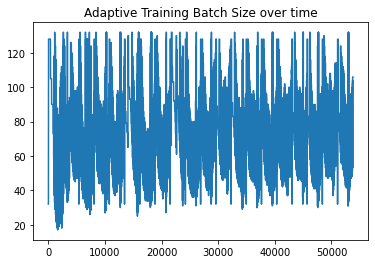

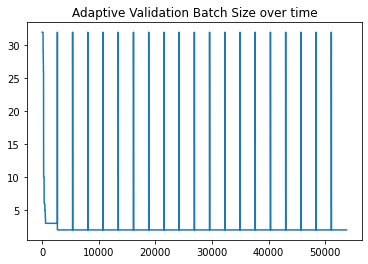

In [41]:
if BYPASS_PREVIOUS_SECTION or not DATASET_ITERATOR_APPROACH:
  # Plot the batch size over time :-)
  plt.plot(BPATH)
  plt.title('Adaptive Training Batch Size over time')
  plt.show()
  plt.plot(BPATH_val)
  plt.title('Adaptive Validation Batch Size over time')
  plt.show()

In [42]:
# Process the metrics into the correct format 
if BYPASS_PREVIOUS_SECTION or not DATASET_ITERATOR_APPROACH:

  # How unbalanced was the database? For the training dataset
  train_unbalance = 0
  S,T = 0,0
  for yp in yplus_train:
    T += yp[1]
    S += yp[0]
  train_unbalance = S / T


  # How unbalanced was the database? For the validation dataset
  val_unbalance = 0
  S,T = 0,0
  for yp in yplus_val:
    T += yp[1]
    S += yp[0]
  val_unbalance = S / T

  print(f'The training fraction of positives was: {train_unbalance}')
  print(f'The vallidation fraction of positives was: {val_unbalance}')
    
  # Postprocess TFRecord data :-)
  ks = list(METRICS.keys())
  PROCESSED_METRICS = {}
  for k in ks:
    PROCESSED_METRICS[k] = []
    for y in METRICS[k]:
      S = sum(x[1] for x in y)
      R = sum([x[0] * x[1] / S for x in y])
      PROCESSED_METRICS[k].append(R)

The training fraction of positives was: 0.4933546385938528
The vallidation fraction of positives was: 0.49329414609646755


#<b>Plotting the Neural Net results</b>

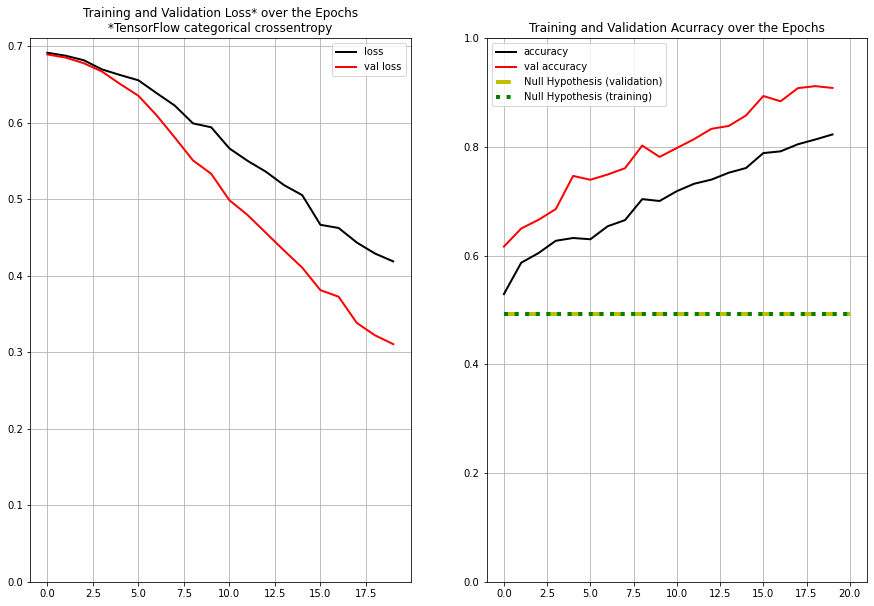

In [45]:
# Display results
if not BYPASS_PREVIOUS_SECTION and DATASET_ITERATOR_APPROACH:
  results = history.history
else:
  results = PROCESSED_METRICS

f,ax = plt.subplots(1,2,figsize=(15,10))

ax[0].plot(results['loss'],label='loss', c='k', lw=2)
ax[0].plot(results['val_loss'], label='val loss', c='r', lw=2)
ax[0].grid()
ax[0].set_title('Training and Validation Loss* over the Epochs\n*TensorFlow categorical crossentropy')
ax[0].set_ylim(0,None)
ax[0].legend()

ax[1].plot(results['categorical_accuracy'],label='accuracy', c='k', lw=2)
ax[1].plot(results['val_categorical_accuracy'], label='val accuracy', c='r', lw=2)
ax[1].set_ylim(0,1)
if DATASET_ITERATOR_APPROACH:
  ax[1].hlines(0.5, 0, EPOCHS, color='y', ls=':', lw=4, label='Null Hypothesis\n(perfect 50% tag balance case)')
else:
  ax[1].hlines(val_unbalance, 0, EPOCHS, color='y', ls='--', lw=4, label='Null Hypothesis (validation)')
  ax[1].hlines(train_unbalance, 0, EPOCHS, color='g', ls=':', lw=4, label='Null Hypothesis (training)')
ax[1].grid()
ax[1].set_title('Training and Validation Acurracy over the Epochs')
ax[1].legend()																																																																																																																																																																				

plt.show()

In [44]:
# Print the raw values of the metrics, just in case we want to use them to make nicer plots 
# without re-running the notebook :O
print(results['loss'])
print(results['val_loss'])
print(results['categorical_accuracy'])
print(results['val_categorical_accuracy'])

[0.691795292201343, 0.6879632847419922, 0.6820181969973967, 0.6700434180061949, 0.6626783986354158, 0.6558195402930723, 0.6390390248740326, 0.6226993733528315, 0.599447459330442, 0.5943641666589038, 0.5667079597330917, 0.5504688831775578, 0.5363056545306865, 0.5187233663599067, 0.5056297779083251, 0.4668255271217548, 0.4626859172618395, 0.4436321160445609, 0.42922189996925003, 0.4189935179357243]
[0.6895832614380494, 0.6855274824913402, 0.6781417607507174, 0.6672453527405326, 0.6509210075074378, 0.6355751316351389, 0.6100795461097722, 0.5809919369972434, 0.5509877501393756, 0.5335527964302204, 0.49895829502080874, 0.47959734499894124, 0.4563875756620407, 0.43326843861562603, 0.41082205587463233, 0.38138074371297886, 0.3727898606251143, 0.3384638255612969, 0.3222836972516114, 0.310786055313646]
[0.529279283105253, 0.5869565235487167, 0.6047120411715223, 0.6273478589879221, 0.6324404762126504, 0.6301421137692417, 0.6540642789271016, 0.6652923548395843, 0.7039548068621291, 0.7005208372138